# Prototype Bayesian models

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel

torch.set_default_tensor_type(torch.DoubleTensor) # set the default to float64
%matplotlib inline

In [47]:
## Generate some simple data

In [48]:
n = 100
x = np.linspace(-10, 10, n)
pt = expit(x + 2. * np.random.normal(size=n))
t = np.random.binomial(n=1, p=pt)
y = 1 + 0.1 * x + 0.2 * t * (x + 2) + 0.4 * np.random.normal(size=n)

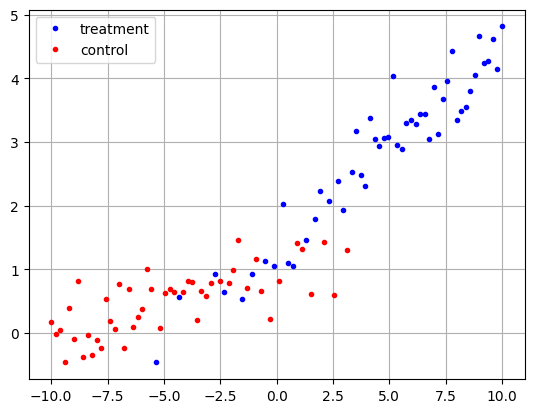

In [49]:
t1 = t == 1
t0 = ~t1

def plot_data():
    plt.plot(x[t1], y[t1], 'b.', label="treatment")
    plt.plot(x[t0], y[t0], 'r.', label="control")
    plt.legend()
    plt.grid()
    
plot_data()   
plt.show()

# Estimators

## Linear regression

In [50]:
X = np.vstack([t, x, t*x]).T
X1 = np.vstack([np.ones(n), x, x]).T
X0 = np.vstack([np.zeros(n), x, np.zeros(n)]).T

In [51]:
lr = LinearRegression().fit(X, y)

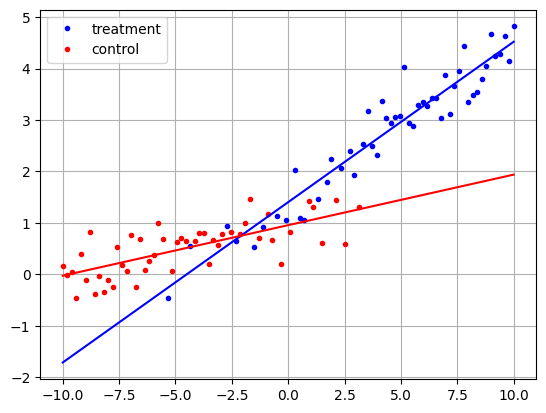

In [52]:
plot_data()   
plt.plot(x, lr.predict(X1), 'b', label="f1")
plt.plot(x, lr.predict(X0), 'r', label="f0")
plt.show()

## Bayesian model

In [53]:
def predict(w_0, w_t, w_x, w_tx, x, t):
    f = w_0 + w_t * t + x.matmul(w_x.T) + t * x.matmul(w_tx.T)
    return f


def model_treatment_intersection(x, t, y):
    # Hyper-Priors
    lambda_prior = dist.Gamma(.1, 1.)
    sigma_prior = dist.Gamma(1., 1.)
    
    # Priors
    n, d = x.shape
    weight_prior = dist.Normal
    p_w0 = weight_prior(0, pyro.sample("l_0", lambda_prior))
    p_wt = weight_prior(0, pyro.sample("l_t", lambda_prior))
    p_wx = weight_prior(torch.zeros(d), pyro.sample("l_x", lambda_prior) * torch.ones(d))
    p_twx = weight_prior(torch.zeros(d), pyro.sample("l_tx", lambda_prior) * torch.ones(d))
    
    # Model weights
    w_0 = pyro.sample("intercept", p_w0)
    w_t = pyro.sample("treatment", p_wt)
    w_x = pyro.sample("confounders", p_wx)
    w_tx = pyro.sample("intersection", p_twx)
    
    # Likelihood
    f = predict(w_0, w_t, w_x, w_tx, x, t)
    sigma = pyro.sample("variance", sigma_prior)
    
    with pyro.plate("data", n):
        likelihood = dist.Normal(f, sigma)
        y = pyro.sample("likelihood", likelihood, obs=y)

In [54]:
samples = 200
warm_up = 500

X_torch = torch.tensor(x[:, np.newaxis])
t_torch = torch.tensor(t)
y_torch = torch.tensor(y)


# Initialize No U-Turn Sampler
nuts_kernel = NUTS(model_treatment_intersection, max_tree_depth=7)
model_mcmc = MCMC(nuts_kernel, num_samples=samples, warmup_steps=warm_up)

# Run the sampler
model_mcmc.run(X_torch, t_torch, y_torch)

Sample: 100%|██████████████████████████| 700/700 [00:48, 14.49it/s, step size=2.94e-01, acc. prob=0.890]


In [55]:
hbr_samples = model_mcmc.get_samples()
w_0s = hbr_samples["intercept"]
w_ts = hbr_samples["treatment"]
w_xs = hbr_samples["confounders"]
w_txs = hbr_samples["intersection"]

f0 = np.zeros((samples, n))
f1 = np.zeros((samples, n))
tt0 = torch.zeros_like(t_torch)
tt1 = torch.ones_like(t_torch)

for s in range(samples):
    f1[s, :] = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], X_torch, tt1)
    f0[s, :] = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], X_torch, tt0)

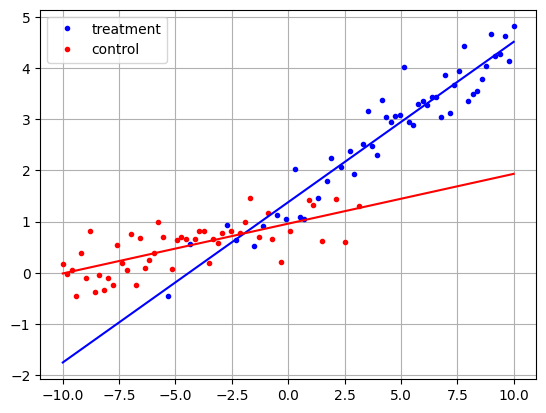

In [56]:
plot_data()   
plt.plot(x, f1.mean(axis=0), 'b', label="f1")
plt.plot(x, f0.mean(axis=0), 'r', label="f0")
plt.show()

## Gaussian process

In [57]:
def kernel_dimensions(KernelClass, Xdims):
    
    class KernelDims(KernelClass):
        
        def __call__(self, X, Y=None, eval_gradient=False):
            Xd = X[:, Xdims]
            Yd = Y
            if Y is not None:
                Yd = Y[:, Xdims]
            return super().__call__(Xd, Yd, eval_gradient)
        
        def diag(self, X):
            Xd = X[:, Xdims]
            return super().diag(Xd)
        
    return KernelDims

In [58]:
Xgp = np.vstack([t, x]).T
Xgp0 = np.vstack([np.zeros_like(t), x]).T
Xgp1 = np.vstack([np.ones_like(t), x]).T

In [59]:
kernel = Matern(nu=1.5) + WhiteKernel()

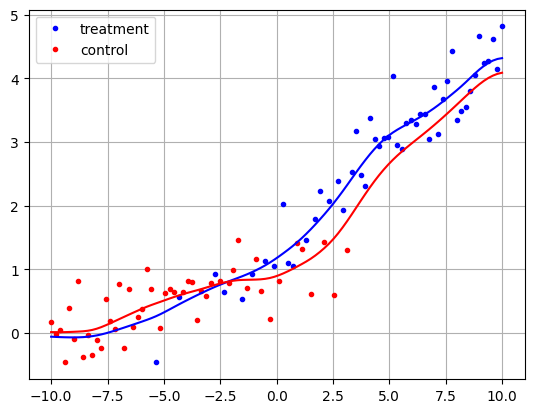

In [60]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(Xgp, y)

plot_data()   
plt.plot(x, gp.predict(Xgp1), 'b', label="f1")
plt.plot(x, gp.predict(Xgp0), 'r', label="f0")
plt.show()

In [79]:
kernel = 1 * kernel_dimensions(Matern, [0])(nu=1.5) \
    + 1 * kernel_dimensions(Matern, [1])(nu=1.5) \
    + WhiteKernel()

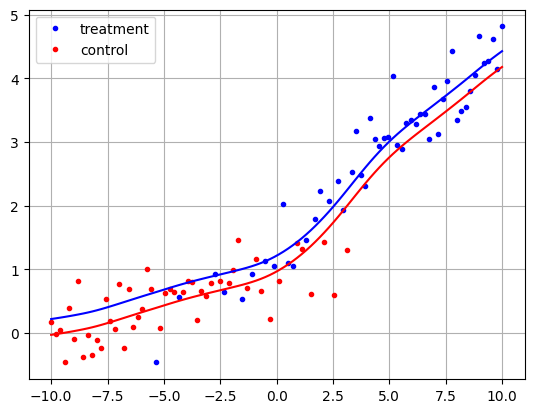

In [80]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(Xgp, y)
plot_data()   
plt.plot(x, gp.predict(Xgp1), 'b', label="f1")
plt.plot(x, gp.predict(Xgp0), 'r', label="f0")
plt.show()

In [81]:
kernel = 1 * kernel_dimensions(Matern, [1])(nu=1.5) \
    * 1 * kernel_dimensions(DotProduct, [0])(sigma_0=0, sigma_0_bounds="fixed") \
    + kernel_dimensions(Matern, [1])(nu=1.5) + WhiteKernel()

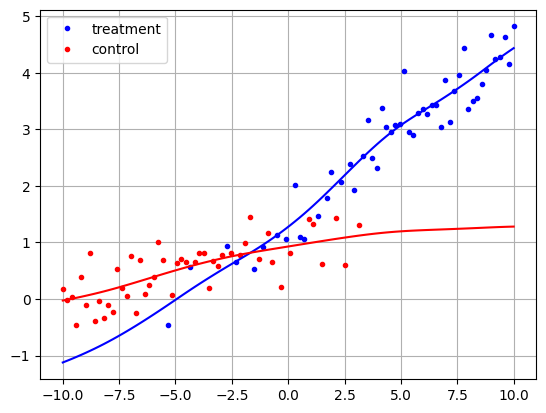

In [82]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(Xgp, y)
plot_data()   
plt.plot(x, gp.predict(Xgp1), 'b', label="f1")
plt.plot(x, gp.predict(Xgp0), 'r', label="f0")
plt.show()

In [83]:
gp.kernel_

1.89**2 * KernelDims(length_scale=30.7, nu=1.5) * 1.89**2 * KernelDims(sigma_0=0) + KernelDims(length_scale=22.9, nu=1.5) + WhiteKernel(noise_level=0.123)